In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.models.network import BuddingLayer
from src.models.training import *

In [2]:
BATCH_SIZE = 64
EPOCHS = 50

In [3]:
class Net(nn.Module):
    def __init__(self, in_features: int, out_size: int):
        super().__init__()
        
        n_in = in_features

        self.bl1 = nn.Linear(n_in, 10)
        self.bl2 = nn.Linear(10, 9)
        self.blout = nn.Linear(9, out_size)
        
    def forward(self, x):
        x = F.relu(self.bl1(x))
        x = F.relu(self.bl2(x))
        x = self.blout(x)

        return x

In [4]:
class CapacityModel(nn.Module):
    def __init__(self, size_in: int, size_out: int, window_size: int, 
                 threshold: float, layers,
                 activation_name: str):
        
        super().__init__()

        self.window_size = window_size
        self.threshold = threshold

        self.activation = nn.ReLU()
        n_in = size_in
        self.layerlist = nn.ModuleList()

        for layer in layers:
            self.layerlist.append(BuddingLayer(n_in, layer, window_size))
            n_in = layer
        self.layerlist.append(BuddingLayer(layers[-1], size_out, window_size))

    def get_saturation(self, best_lipschitz):
        if best_lipschitz is not None:
            return best_lipschitz < self.threshold
        return None

    def forward(self, x, optim=None):
        x, lip = self.layerlist[0].forward(x, optim=optim)
        for i, l in enumerate(self.layerlist[1:]):
            x = self.activation(x)
            saturation = self.get_saturation(lip)
            x, lip = self.layerlist[i+1].forward(x, saturation, optim)

        return x

In [5]:
input_features = "../data/processed/obesity_features.csv"
input_target = "../data/processed/obesity_target.csv"

X = np.genfromtxt(input_features, delimiter=',')
y = np.genfromtxt(input_target, delimiter=',')
X_train, X_test, y_train, y_test = data_split(X, y)

In [6]:
trainloader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
torch.manual_seed(101)
model = CapacityModel(
    X_train.shape[1], len(np.unique(y_train)), window_size=5, threshold=0.01, layers=[10, 9], activation_name='relu'
)
benchmark = Net(X_train.shape[1], len(np.unique(y_train)))

In [10]:
model

CapacityModel(
  (activation): ReLU()
  (layerlist): ModuleList(
    (0): BuddingLayer(
      (buds): ModuleDict()
    )
    (1): BuddingLayer(
      (buds): ModuleDict()
    )
    (2): BuddingLayer(
      (buds): ModuleDict()
    )
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
bench_optim = Adam(benchmark.parameters(), lr=0.01)

In [12]:
losses = []
for epoch in range(EPOCHS):
    y_pred = model.forward(X_train, optimizer)
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    print(f"Epoch: {epoch+1}  Loss: {loss.item():10.3f}")
    print(f"SATURATION:\nBL2: {model.layerlist[1].saturated_neurons}\nBLout: {model.layerlist[2].saturated_neurons}")
    #print(model.state_dict())
    #print(model.get_extra_params())
    print("=========================================================================================\n")
    
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    

Epoch: 1  Loss:      1.982
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

Epoch: 2  Loss:      1.969
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

Epoch: 3  Loss:      1.957
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

Epoch: 4  Loss:      1.947
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

Epoch: 5  Loss:      1.937
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, F

/home/dominik/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 18  Loss:      1.924
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True, False,  True,  True, False,  True,  True, False])

Epoch: 19  Loss:      1.878
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True, False,  True,  True, False,  True,  True, False])

Epoch: 20  Loss:      1.838
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True, False,  True,  True, False,  True,  True, False])

Epoch: 21  Loss:      1.813
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True, False,  True,  True, False,  True,  True, False])

Epoch: 22  Loss:      1.803
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True, False,  True,  True, False,  Tr

Epoch: 46  Loss:      1.761
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])

Epoch: 47  Loss:      1.634
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])

Epoch: 48  Loss:      1.536
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])

Epoch: 49  Loss:      1.478
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])

Epoch: 50  Loss:      1.471
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False,  True, False])
BLout: tensor([ True,  True,  True,  True,  True,  True,  Tr

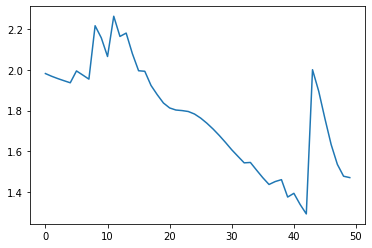

In [13]:
plt.plot(losses)

In [14]:
losses = []
for epoch in range(EPOCHS):
    y_pred = benchmark.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    print(f"Epoch: {epoch+1}  Loss: {loss.item():10.3f}")
    print("=========================================================================================\n")
    
    bench_optim.zero_grad()
    loss.backward()
    bench_optim.step()

Epoch: 1  Loss:      1.970

Epoch: 2  Loss:      1.957

Epoch: 3  Loss:      1.946

Epoch: 4  Loss:      1.935

Epoch: 5  Loss:      1.923

Epoch: 6  Loss:      1.908

Epoch: 7  Loss:      1.891

Epoch: 8  Loss:      1.874

Epoch: 9  Loss:      1.858

Epoch: 10  Loss:      1.840

Epoch: 11  Loss:      1.820

Epoch: 12  Loss:      1.796

Epoch: 13  Loss:      1.771

Epoch: 14  Loss:      1.744

Epoch: 15  Loss:      1.715

Epoch: 16  Loss:      1.682

Epoch: 17  Loss:      1.647

Epoch: 18  Loss:      1.610

Epoch: 19  Loss:      1.570

Epoch: 20  Loss:      1.528

Epoch: 21  Loss:      1.486

Epoch: 22  Loss:      1.442

Epoch: 23  Loss:      1.396

Epoch: 24  Loss:      1.350

Epoch: 25  Loss:      1.304

Epoch: 26  Loss:      1.258

Epoch: 27  Loss:      1.214

Epoch: 28  Loss:      1.173

Epoch: 29  Loss:      1.133

Epoch: 30  Loss:      1.097

Epoch: 31  Loss:      1.062

Epoch: 32  Loss:      1.031

Epoch: 33  Loss:      1.002

Epoch: 34  Loss:      0.975

Epoch: 35  Loss:      0

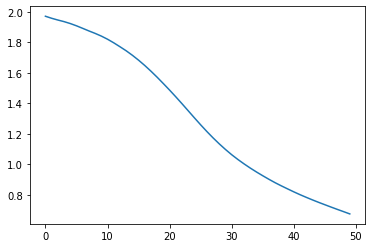

In [15]:
plt.plot(losses)